In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import datetime

def categorize(x):
    if x <= 30: return 0
    elif x <= 50: return 1
    else: return 2

def preprocess_3h(df):

    x = df.copy()

    x['category'] = x['Kp*10'].apply(categorize)

    x['dttm'] = x.apply(
        lambda y: datetime.datetime(
            int(y.year), int(y.month), 
            int(y.day), int(y['hour from']), 0), axis=1)
    
    x_3h = x.sort_values(by='dttm').iloc[:: 3]
    return x_3h

ROOT_PATH = '/content/drive/MyDrive/kp_data'

import os
import glob

files = glob.glob(os.path.join(ROOT_PATH, '*'))

files = dict(map(lambda x: (x.split('/')[-1], x), files))

df = pd.read_csv(
    files['All_browse_data_без_погружения_19971021_20211231_с_пропусками.csv'], 
    encoding='cp1251', na_values='N').pipe(preprocess_3h)
print(df.shape)
df.head()

(70776, 65)


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,...,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,category,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,...,0.715307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 00:00:00
3,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,...,0.318573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 03:00:00
6,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,...,0.070838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 06:00:00
9,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,...,0.501584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 09:00:00
12,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,...,1.011042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 12:00:00


In [2]:
all_variables = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP', 'dttm', 'category'
 ]

predictors  = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP',
 ]

def simple_preprocessing(df):
    x = df.copy()

    x = x.bfill()

    return x

def _choose_suffix_name(forward: bool, suffix_name: str) -> str:
    if suffix_name is not None:
        return suffix_name
    else:
        return 'lead' if forward else 'lag'

def _trim(df: pd.DataFrame, forward: bool, trim: bool, lags: int) -> pd.DataFrame:
    if trim and forward:
        return df.iloc[: -lags]
    elif trim:
        return df.iloc[lags: ]
    else:
        return df

def add_lags(df: pd.DataFrame, subset: list=None, forward: bool=False,
             lags: int=1, trim: bool=False, suffix_name: str=None,
             return_cols=False) -> pd.DataFrame:

    suffix_name = _choose_suffix_name(forward, suffix_name)

    x = df.copy()

    digits = len(str(lags))

    columns = []

    if not isinstance(lags, int):
        raise ValueError(f'Lags should be int, {type(lags)} type prodided')
    elif lags < 0:
        raise ValueError(f'Lags should be non-negative')
    elif lags == 0:
        return x
    elif subset is None:
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'

            x = x.join(x.shift(lag).add_suffix(column_suffix))
        
        columns = x.columns.tolist()

    elif isinstance(subset, list):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'
            tmp = x.loc[:, subset].shift(lag).add_suffix(column_suffix)
            columns.extend(tmp.columns)
            x = x.join(tmp)

    elif isinstance(subset, str):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'{subset}_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).rename(column_name))
    else:
        raise ValueError(f'Subset should be str or list, providided type {type(subset)}')

    if return_cols:
        return _trim(x, forward, trim, lags), columns
    else:
        return _trim(x, forward, trim, lags)


def get_train_test(df: pd.DataFrame, columns: list, 
                   forward_steps: int, backward_steps: int, 
                   last: str='24m') -> tuple:

    ts_df_back, lag_cols = add_lags(df, lags=backward_steps, forward=False, 
                                    trim=True, subset=columns, 
                                    return_cols=True)
    lag_cols.extend(columns)
    ts_df_back_test = ts_df_back.set_index('dttm').last(last)

    index_test = ts_df_back_test.index
    ts_df_back_train = ts_df_back.set_index('dttm').drop(index_test)

    df_train, lead_cols = add_lags(ts_df_back_train, lags=forward_steps,
                                   forward=True, trim=True, 
                                   subset='category', return_cols=True)
    df_test, lead_cols = add_lags(ts_df_back_test, lags=forward_steps, 
                                  forward=True, trim=True, 
                                  subset='category', return_cols=True)

    return df_train.reset_index(), lag_cols, df_test.reset_index(), lead_cols

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score

from types import FunctionType

def columnwise_score(scoring_func: FunctionType, 
                     preds_df: pd.DataFrame, 
                     true_df: pd.DataFrame,
                     **kwargs) -> pd.Series:

    score = pd.Series(dtype='float64')
    for (column_pred, y_pred), (columns_true, y_true) in zip(preds_df.iteritems(), 
                                                             true_df.iteritems()):
        score[column_pred] = scoring_func(y_pred, y_true, **kwargs)
    
    return score

In [3]:
df_train, lag_cols, df_test, lead_cols = get_train_test(df, predictors, 24 // 3, 24)

In [4]:
X_train, y_train = df_train[lag_cols], df_train[lead_cols[0]]
X_test, y_test = df_test[lag_cols], df_test[lead_cols]

In [5]:
X_train.shape, X_test.shape

((65072, 200), (5664, 200))

In [ ]:
X_train.isna().sum()

Kp*10_lag_01         0
Dst_lag_01           0
B_x_lag_01         120
B_gsm_y_lag_01     120
B_gsm_z_lag_01     120
                  ... 
B_gsm_y            120
B_gsm_z            120
B_magn             120
SW_spd            1073
H_den_SWP         1073
Length: 200, dtype: int64

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [ ]:
model = XGBClassifier(n_jobs=-1, random_state=17)

params = {
    'max_depth': [2, 4, 6, 8, 10,]
}

skf = StratifiedKFold(n_splits=5,)

gcv = GridSearchCV(model, params, scoring='f1_macro', cv=skf, verbose=2)

gcv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................max_depth=2; total time= 2.7min
[CV] END ........................................max_depth=2; total time= 2.7min
[CV] END ........................................max_depth=2; total time= 2.7min
[CV] END ........................................max_depth=2; total time= 2.7min
[CV] END ........................................max_depth=2; total time= 2.7min
[CV] END ........................................max_depth=4; total time= 5.4min
[CV] END ........................................max_depth=4; total time= 5.4min
[CV] END ........................................max_depth=4; total time= 5.3min
[CV] END ........................................max_depth=4; total time= 5.3min
[CV] END ........................................max_depth=4; total time= 5.3min
[CV] END ........................................max_depth=6; total time= 8.1min
[CV] END ........................................

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(n_jobs=-1, random_state=17),
             param_grid={'max_depth': [2, 4, 6, 8, 10]}, scoring='f1_macro',
             verbose=2)

In [ ]:
print(gcv.best_score_, gcv.best_params_)

0.6486509518145569 {'max_depth': 2}


In [ ]:

scores = np.array(
    [gcv.cv_results_[f'split{i}_test_score'] for i in range(5)]).T

In [ ]:
mean_scores = scores.mean(axis=1)

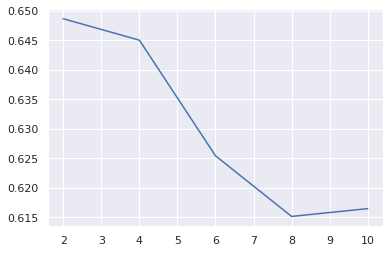

In [ ]:
plt.plot(params['max_depth'], mean_scores)

In [ ]:
model = XGBClassifier(n_jobs=-1, random_state=17, max_depth=2)

params = {
    'n_estimators': np.arange(50, 350, 50)
}

skf = StratifiedKFold(n_splits=5,)

gcv = GridSearchCV(model, params, scoring='f1_macro', cv=skf, verbose=2)

gcv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ....................................n_estimators=50; total time= 1.4min
[CV] END ....................................n_estimators=50; total time= 1.4min
[CV] END ....................................n_estimators=50; total time= 1.4min
[CV] END ....................................n_estimators=50; total time= 1.4min
[CV] END ....................................n_estimators=50; total time= 1.4min
[CV] END ...................................n_estimators=100; total time= 2.7min
[CV] END ...................................n_estimators=100; total time= 2.7min
[CV] END ...................................n_estimators=100; total time= 2.7min
[CV] END ...................................n_estimators=100; total time= 2.7min
[CV] END ...................................n_estimators=100; total time= 2.7min
[CV] END ...................................n_estimators=150; total time= 4.0min
[CV] END ...................................n_est

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(max_depth=2, n_jobs=-1, random_state=17),
             param_grid={'n_estimators': array([ 50, 100, 150, 200, 250, 300])},
             scoring='f1_macro', verbose=2)

In [ ]:
scores = np.array(
    [gcv.cv_results_[f'split{i}_test_score'] for i in range(5)]).T
mean_scores = scores.mean(axis=1)

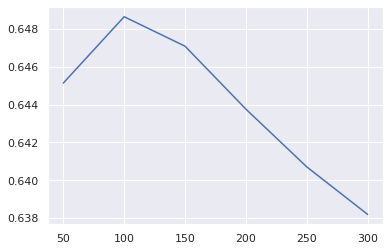

In [ ]:
plt.plot(params['n_estimators'], mean_scores)

In [ ]:
print(gcv.best_score_, gcv.best_params_)

0.6486509518145569 {'n_estimators': 100}


In [10]:
from sklearn.multioutput import MultiOutputClassifier


model = MultiOutputClassifier(
    XGBClassifier(n_jobs=-1, random_state=17, 
                  max_depth=2, n_estimators=100))



In [8]:
df_train, lag_cols, df_test, lead_cols = get_train_test(
    df.pipe(simple_preprocessing), predictors, 24 // 3, 24)

X_train, y_train = df_train[lag_cols], df_train[lead_cols]
X_test, y_test = df_test[lag_cols], df_test[lead_cols]

In [11]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(max_depth=2, n_jobs=-1,
                                              random_state=17))

In [12]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

In [13]:
preds.category_lead_1.value_counts()

0.0    5446
1.0     207
2.0      11
Name: category_lead_1, dtype: int64

In [14]:
preds.shape

(5664, 8)

In [15]:
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

In [16]:
f1_weighted_res.to_csv(os.path.join(ROOT_PATH, 'xgb_cv.csv'))

In [17]:
f1_weighted_res

category_lead_1    0.605911
category_lead_2    0.524323
category_lead_3    0.394505
category_lead_4    0.334590
category_lead_5    0.325399
category_lead_6    0.323850
category_lead_7    0.322178
category_lead_8    0.320594
dtype: float64

In [18]:
from sklearn.metrics import confusion_matrix

def columnwise_confusion_matrix(preds_df: pd.DataFrame, y_true_df: pd.DataFrame, 
                                categories: list) -> list:

    all_matrices = {}
    for col in preds_df.columns:

        matrix = pd.DataFrame(confusion_matrix(y_true_df[col], preds_df[col]),
                              index=categories, columns=categories)
        all_matrices[col] = matrix

    return all_matrices

In [19]:
confusion_matrices = columnwise_confusion_matrix(preds, y_test, [0, 1, 2])

In [20]:
matr_path = os.path.join(ROOT_PATH, 'metrics')

import os
if not os.path.exists(matr_path): os.mkdir(matr_path)

for key, matrix in confusion_matrices.items():

    matrix.to_excel(
        os.path.join(matr_path, f'xgb_cv_confusion_matrix_{key}.xlsx'))

In [21]:
import seaborn as sns

def plot_all_confusion_matrices(matrices: list, 
                                h: int=2, w: int= 2, **kwargs) -> None:

    n = len(matrices)

    f, ax = plt.subplots(n, 1, sharex=True)

    for i, (key, matrix) in enumerate(matrices.items()):
        sns.heatmap(matrix.astype('int'), ax=ax[i], **kwargs)
        ax[i].set_title(key)

    f.set_figheight(n * h)
    f.set_figwidth(w)

    plt.tight_layout()



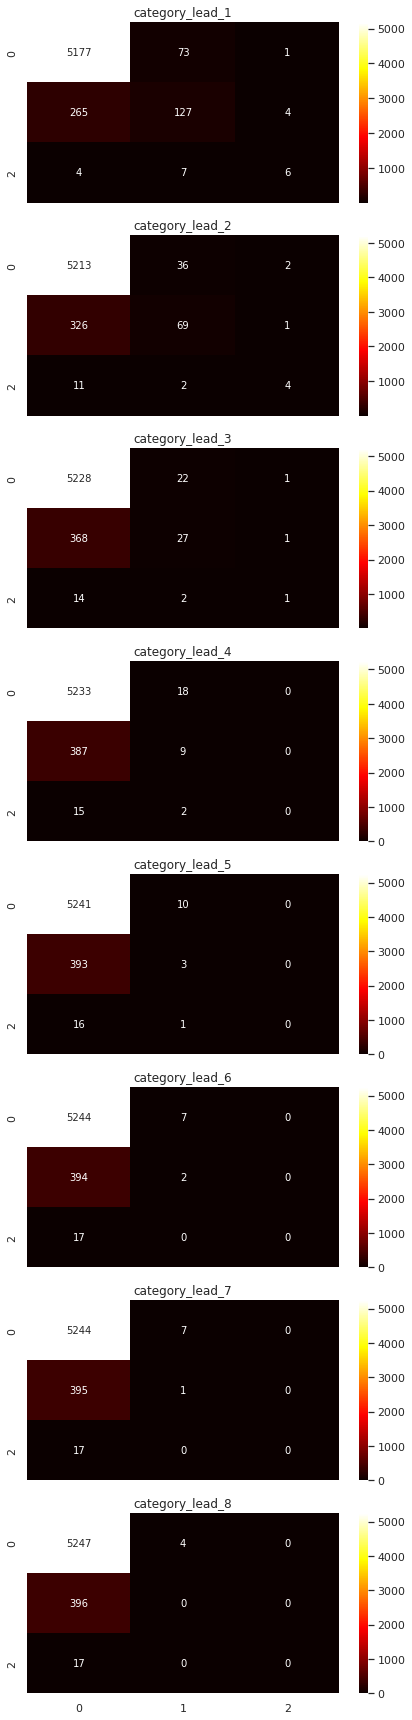

In [22]:
plot_all_confusion_matrices(confusion_matrices, h=3, w=6, annot=True, fmt='.5g', cmap='hot')